In this example, we explore how evolution models can be implemented efficiently. An example of an evolution model is given in [Botero et al., 2015](http://www.pnas.org/content/112/1/184.full), but many are found throughout literature. In those models, some individuals (in this example animals) form a population, and each individual randomly adjusts its genome (i.e., mutates). Depending on how well the individuals fit into their environment, they produce more or less offspring, thus altering the composition of the population (survival of the fittest).

In this simple example, the fitness of the individuals will just depend on the distance of their genome to some perfect state, and the population size is held constant by cloning / killing random animals.

In [1]:
%matplotlib inline
%load_ext cython
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set("talk")

### Naive Python implementation

This implementation uses two classes, one for the animals, and one for the population. During one time step, each animal mutates five times, then it reproduces. The fitness has the shape of a Gaussian around an optimal value $i=10$.

In [2]:
class PyAnimal:
    def __init__(self,initial=0):
        self.i = initial
    def mutate(self):
        self.i += np.random.randn()
    def fitness(self):
        return np.exp(-(self.i-10)**2)
    def state(self):
        return self.i
    
class PyPopulation:
    def __init__(self,animals):
        self.animals = animals
        
    def do_step(self):
        for animal in self.animals:
            for _ in range(5):
                animal.mutate()
        fitnesses = [a.fitness() for a in self.animals]
        offspring = np.random.poisson(fitnesses / np.mean(fitnesses))
        born_animals = [PyAnimal(a.state()) for a in np.repeat(self.animals, offspring)]
        if len(born_animals) > len(self.animals):
            born_animals = np.random.choice(born_animals,len(self.animals)).tolist()
        else:
            clones = np.random.choice(born_animals,len(self.animals) - len(born_animals))
            born_animals = born_animals + [PyAnimal(a.state()) for a in clones]
        self.animals = born_animals
        
    def state(self):
        return [a.state() for a in self.animals]

Let's check the performance and the resulting distribution of genes:

1 loop, best of 3: 1.04 s per loop


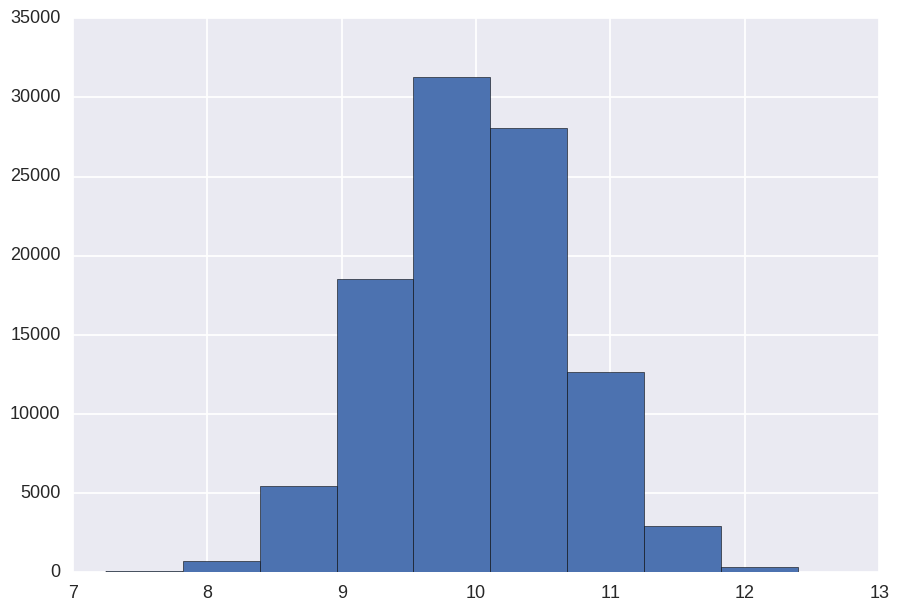

In [3]:
animals = [PyAnimal() for i in range(100000)]
population = PyPopulation(animals)
%timeit population.do_step()
plt.hist(population.state());

In [4]:
%prun -l 10 -q -T profile population.do_step()
with open("profile","r") as f:
    print(f.read())

 
*** Profile printout saved to text file u'profile'. 
         1400043 function calls in 2.175 seconds

   Ordered by: internal time
   List reduced from 32 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.724    0.724    2.174    2.174 <ipython-input-2-b4af97439b11>:15(do_step)
   500000    0.386    0.000    0.588    0.000 <ipython-input-2-b4af97439b11>:4(mutate)
   100000    0.377    0.000    0.377    0.000 <ipython-input-2-b4af97439b11>:6(fitness)
        4    0.230    0.058    0.230    0.058 {numpy.core.multiarray.array}
   500000    0.203    0.000    0.203    0.000 {method 'randn' of 'mtrand.RandomState' objects}
        1    0.146    0.146    0.146    0.146 {method 'choice' of 'mtrand.RandomState' objects}
   100001    0.048    0.000    0.048    0.000 {range}
   100000    0.023    0.000    0.023    0.000 <ipython-input-2-b4af97439b11>:2(__init__)
   100000    0.019    0.000    0.019    0.000 <ipython-input-2-b4

The implementation seems to work (the resulting distribution is centered around 10), but it is quite slow. Profiling the code reveals that most of the time is spent directly in the `do_step`, `mutate` and `fitness` functions, while the NumPy functions only play a minor roll. It thus seems like the slow runtime is mainly caused by the overhead when creating and accessing the class members or calling class methods.

### Cython implementation

Since member access is much faster in Cython, it seems obvious to try and cythonize the Python implementation. A first iteration may look like this:

In [5]:
%%cython -c=-O3
# cython: profile=True

import numpy as np
cimport numpy as np

cdef class CyAnimal:
    cdef double i
    
    def __init__(self, double initial=0):
        self.i = initial
    cpdef void mutate(self):
        self.i += np.random.randn()
    cpdef double fitness(self):
        return np.exp(-(self.i-10)**2)
    cpdef double state(self):
        return self.i

cdef class CyPopulation:
    cdef list animals
    
    def __init__(self,list animals):
        self.animals = animals
        
    cpdef void do_step(self):
        cdef list fitnesses, offspring, born_animals, clones
        
        for animal in self.animals:
            for _ in range(5):
                animal.mutate()
        fitnesses = [a.fitness() for a in self.animals]
        offspring = np.random.poisson(fitnesses / np.mean(fitnesses)).tolist()
        born_animals = [CyAnimal(a.state()) for a in np.repeat(self.animals, offspring)]
        if len(born_animals) > len(self.animals):
            born_animals = np.random.choice(born_animals,len(self.animals)).tolist()
        else:
            clones = np.random.choice(born_animals,len(self.animals) - len(born_animals)).tolist()
            born_animals = born_animals + [CyAnimal(a.state()) for a in clones]
        self.animals = born_animals
            
    cpdef list state(self):
        return [animal.state() for animal in self.animals]

1 loop, best of 3: 548 ms per loop
100000


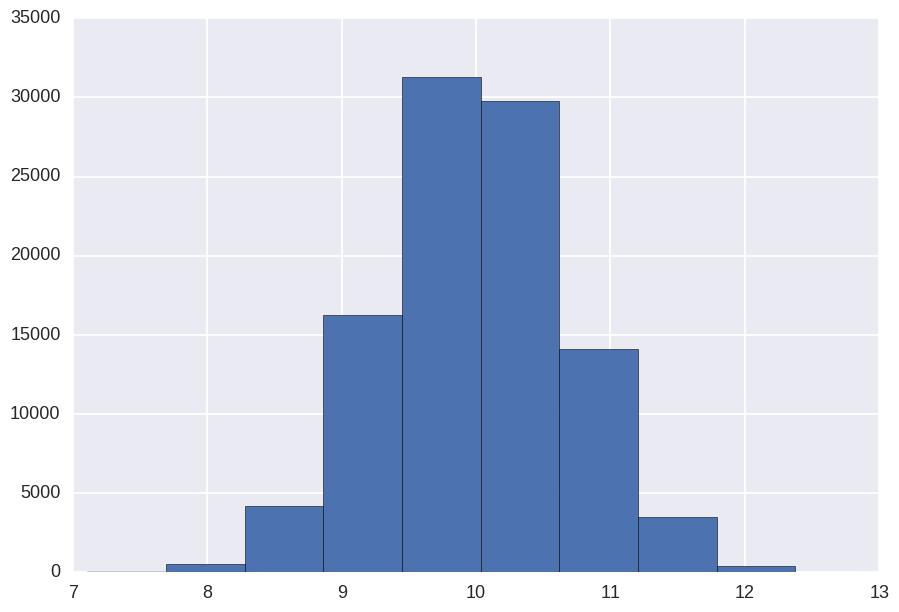

In [6]:
animals = [CyAnimal() for i in range(100000)]
population = CyPopulation(animals)
%timeit population.do_step()
plt.hist(population.state())
print(len(population.state()))

In [7]:
%prun -l 10 -q -T profile population.do_step()
with open("profile","r") as f:
    print(f.read())

 
*** Profile printout saved to text file u'profile'. 
         1500037 function calls in 0.945 seconds

   Ordered by: internal time
   List reduced from 32 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.316    0.316    0.945    0.945 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:24(do_step)
   500000    0.187    0.000    0.187    0.000 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:11(mutate)
   100000    0.155    0.000    0.155    0.000 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:13(fitness)
   500000    0.114    0.000    0.301    0.000 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:11(mutate (wrapper))
        4    0.109    0.027    0.109    0.027 {numpy.core.multiarray.array}
   100000    0.024    0.000    0.178    0.000 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:13(fitness (wrapper))
   100000    0.020    0.000    0.025    0.000 _cython_magic_d5f1817b235c360a3ecaa1c007dbe625.pyx:15(

So, just by adding a few types we gain about double the performance, which is alright, but not really mind-blowing. Also, it seems like the performance bottleneck in `mutate` and `fitness` is still present (there are still lots of Python interactions). How can we eliminate this? One solution is to implement the animal class in pure C++ and interface it through Cython.

### C++ Wrapper

Since the animals are now implemented in C++, we cannot use the NumPy functions anymore to create random numbers, but the C++ standard library provides random number generators anyway. Just make sure to set a different random seed for every animal (otherwise your whole population will evolve into the same direction).

In [8]:
%%writefile cppanimal.h
#include <math.h>
#include <random>

class CppAnimal {
    private:
        std::default_random_engine generator;
        std::normal_distribution<double> distribution;
        double i;
    public:
        CppAnimal(double initial):i(initial), generator(std::rand()), 
                  distribution(0.0,1.0) {}
        void mutate() {i += distribution(generator);}
        double fitness() {return exp(-pow(i-10,2));}
        double state() {return i;}
};

Writing cppanimal.h


The class CppAnimal from the external file cppanimal.h can then be interfaced using the `extern` keyword from Cython. You just need to specify which functions should be interfaced to Python. Also note the different compiler flags (`-+` to enable C++, and `-I .` to tell the compiler that it should look in the current directory for `cppanimal.h`).

Since `CppAnimal` is implemented in pure C++, we cannot put it into a Python list without wrapping it. Instead, we use a C++ `vector` to contain the animals, which enables us to loop over the animals in C-speed. However, this makes the animals inaccessible from Python, so we need to provide a new Cython method `create_animal`.

In [9]:
%%cython -+ -I . -c=-O3
# cython: profile=True

from libcpp.vector cimport vector
import numpy as np
cimport numpy as np

cdef extern from "cppanimal.h":
    cdef cppclass CppAnimal:
        CppAnimal(double initial)
        void mutate()
        double fitness()
        double state()

cdef class CppPopulation:
    cdef vector[CppAnimal] animals
    
    cpdef create_animal(self,double initial=0):
        self.animals.push_back(CppAnimal(initial))
    cpdef void do_step(self):
        cdef int i, c
        cdef np.ndarray[np.float_t,ndim=1] fitnesses = np.empty(self.animals.size(), dtype=np.float)
        cdef vector[CppAnimal] born_animals
        cdef np.ndarray[np.int_t,ndim=1] offspring, clones
        cdef double c_state
        
        for i in range(self.animals.size()):
            for _ in range(5):
                self.animals[i].mutate()
            fitnesses[i] = self.animals[i].fitness()
        offspring = np.random.poisson(fitnesses / np.mean(fitnesses))
        for i in range(self.animals.size()):
            for k in range(offspring[i]):
                born_animals.push_back(CppAnimal(self.animals[i].state()))
        if born_animals.size() > self.animals.size():
            clones = np.random.choice(np.arange(born_animals.size()), 
                                      born_animals.size() - self.animals.size(),
                                      replace=False)
            for c in clones:
                born_animals.erase(born_animals.begin() + c)
        else:
            clones = np.random.choice(np.arange(self.animals.size()),
                                      self.animals.size() - born_animals.size())
            for c in clones:
                born_animals.push_back(CppAnimal(self.animals[c].state()))
        self.animals = born_animals
            
    cpdef list state(self):
        cdef list state_list
        cdef int i
        state_list = []
        for i in range(self.animals.size()):
            state_list.append(self.animals[i].state())
        return state_list

10 loops, best of 3: 99.5 ms per loop
100000


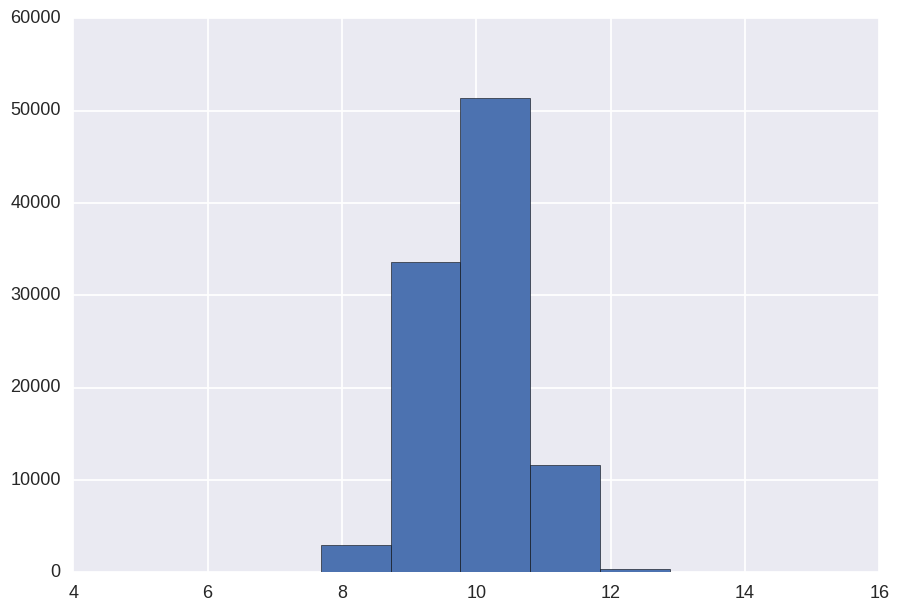

In [10]:
population = CppPopulation()
[population.create_animal() for _ in range(100000)]
%timeit population.do_step()
plt.hist(population.state())
print(len(population.state()))

In [11]:
%prun -l 10 -q -T profile population.do_step()
with open("profile","r") as f:
    print(f.read())

 
*** Profile printout saved to text file u'profile'. 
         35 function calls in 0.088 seconds

   Ordered by: internal time
   List reduced from 22 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.088    0.088    0.088    0.088 _cython_magic_25dcf57a7137e4c774e379e203346f3e.pyx:19(do_step)
        4    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 _methods.py:53(_mean)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2433(prod)
        1    0.000    0.000    0.000    0.000 _methods.py:43(_count_reduce_items)
        3    0.000    0.000    0.000    0.000 numeric.py:484(asanyarray)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2843(mean)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:1900(any)
        1    0.000    0.000    0.088    0.088 <string>:1(<module>)
        2    0.000    0.000    0.000    0

Implementing the animal class in C++ and using C++-vectors as containers gives us a nice speedup from about 400 ms to 60 ms. My Cython code is also far from perfect, since it still has some Python interactions when calling the NumPy functions. You could probably create some lightning fast code if you also implemented those yourself in Cython or even C++.

But, on the other hand, if you are able to write this code in Cython/C++ without using any Python interactions, why are you even using Python in the first place? Doing so eliminates most of the advantages that Python offers, so you might as well write your model entirely in C++, and just do the post-processing in Python. What if the design of the module was flawed from the very beginning? Let's start from scratch.

### Doing it the Python way

My first impulse to represent animals and populations as instances of a class might make intuitive sense, but in the end, it is an abstraction that prevents us from writing *elegant* code. The approach was to loop over all animals and do things one-by-one. As we have seen in example 2, this is usually a really bad idea. After all, animals can just be represented by numbers - say, their genome, or a position in space, or a lifetime fitness. So, let's create a population that is just a structured array of numbers, with four fields:

In [12]:
def create_population(n):
    pop = np.zeros(n, dtype=[('a','<f8'),('b','<f8'),('position','<i8'),('supergene','<f8')])
    for f in pop.dtype.fields:
        pop[f] = np.random.randn(n)*5
    return pop

In [13]:
pop = create_population(10)
print(pop["position"])
print(pop["supergene"])

[-5  3  2 -1  4 -2  0 -3  1  2]
[  5.2386145   -4.46564777   2.67072887  -7.59499018   6.97302314
   4.16067989  -5.04081742  -0.68920514  11.86430644   8.04570278]


The NumPy interface allows us to operate *on the whole population at once*:

In [14]:
def mutate(population):
    n = len(population)
    population["a"] += np.random.randn(n)
    population["b"] += 2.5*np.random.randn(n) + 0.25
    population["supergene"] += np.random.randn(n)
    population["position"] += np.random.randint(-1,2,size=n)
    
def fitness(population):
    fit_fun = lambda x,t: np.exp(-np.power(population[x]-t,2))
    return fit_fun("a",15) + fit_fun("b",2.5) \
             + fit_fun("supergene",10) + fit_fun("position",0)

def do_step(population):
    n = len(population)
    for _ in range(5):
        mutate(population)
    fitnesses = fitness(population)
    offspring = np.random.poisson(fitnesses / np.mean(fitnesses))
    population = np.repeat(population,offspring)
    if len(population) > n:
        population = np.random.choice(population,n,replace=False)
    elif len(population) < n:
        clones = np.random.choice(np.arange(len(population)),
                                  n-len(population),replace=False)
        clone_rep = np.ones(len(population), dtype=np.int)
        clone_rep[clones] = 2
        population = np.repeat(population,clone_rep)
    return population

Just look at the sheer length of this code, compared to the complicated implementations above. If you want, you can also put those functions into a population class that holds the animals as a member array to keep your namespace clean.

Representing the population as a structured array also allows for nice interactions with other Python packages (here Pandas and Seaborn):

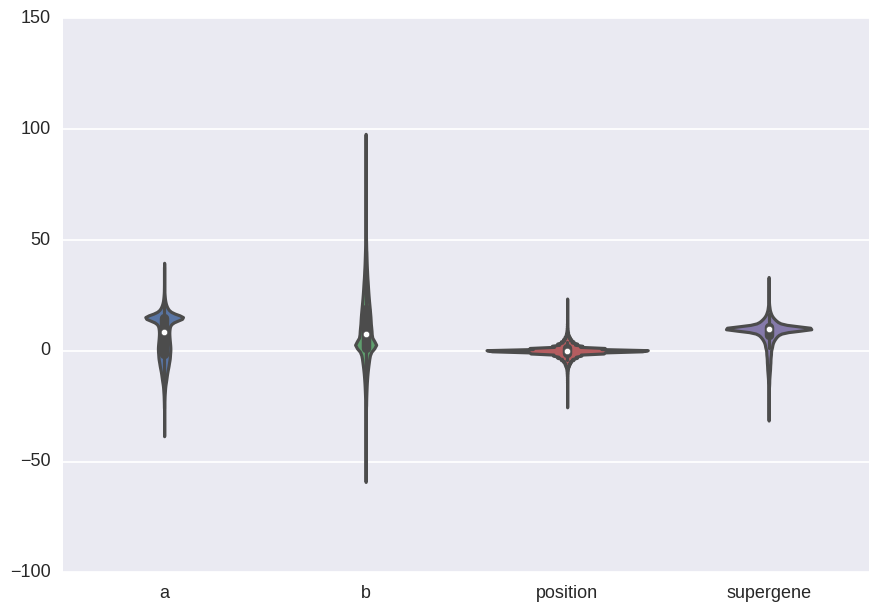

In [15]:
pop = create_population(100000)
for _ in range(10):
    pop = do_step(pop)
sns.violinplot(data=pd.DataFrame(pop));

And, finally, let's have a look at performance:

In [16]:
pop = create_population(100000)
%timeit do_step(pop)

1 loop, best of 3: 202 ms per loop


So, completely un-optimized Python code with *four genes instead of one* is only slower by a factor of two than the C++/Cython implementation before. What do we learn from that?

#### Bottom line: don't be stupid™

- Don't get carried away by unnecessary abstraction. Think in terms of clusters, not single objects.
- Don't try to apply low-level logic to high-level languages. Chances are, you will make your life miserable.
- Before optimizing a solution, ask yourself whether your abstraction makes sense.
- Use the tools that you are given (in this case NumPy). There are lots of developers thinking about low-level implementations so you don't have to (that's why we all like Python, remember).

That concludes this example, and this series. Thank you for reading, and don't hesitate to contact me if you have questions or if you have a suggestion on how to improve my code. I'm always happy to learn.